## Importing Necessary Libraries

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np

# Deep Learning
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

## Downloading the data 
The below link contains a dataset of numerous languages and its translation to English.

http://www.manythings.org/anki/

## Reading the data

In [19]:
with open('mar-eng/mar.txt','r') as f:
      data = f.read()

In [4]:
data

'Go.\tजा.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #3138228 (sabretou)\nRun!\tपळ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138217 (sabretou)\nRun!\tधाव!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138218 (sabretou)\nRun!\tपळा!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138219 (sabretou)\nRun!\tधावा!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138220 (sabretou)\nWho?\tकोण?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #3138225 (sabretou)\nWow!\tवाह!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6728118 (sabretou)\nDuck!\tखाली वाका!\tCC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #7731217 (Nativemarathi)\nFire!\tआग!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #3232248 (sabretou)\nFire!\tफायर!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #3232249 (sabretou)\nHelp!\tवाचवा!\tCC-BY 2.0 

## Building a Dataset

In [5]:
# Split the data into lines
uncleaned_data_list = data.split('\n')

# Limit the data to the first 38695 lines
uncleaned_data_list = uncleaned_data_list[:38695]

# Initialize empty lists for both English and Marathi Words
english_word = []
marathi_word = []

# Extract English and Marathi words
for line in uncleaned_data_list:
    parts = line.split('\t')[:-1]
    english_word.append(parts[0])
    marathi_word.append(parts[1])

# Create a DataFrame and put the words in it
language_data = pd.DataFrame({'English': english_word, 'Marathi': marathi_word})

# Save to a CSV file
language_data.to_csv('language_data.csv', index=False)

In [6]:
# language_data.head()
language_data.tail()

English                            Marathi
38690  I don't see your name on the list.     मला तुमचं नाव यादीत दिसत नाही.
38691  I don't think that was your fault.   तुझी चूक होती असं मला वाटत नाही.
38692  I don't think that was your fault.  तुमची चूक होती असं मला वाटत नाही.
38693  I don't understand English at all.      मला इंग्रजी अजिबात समजत नाही.
38694  I don't want to do that every day.        मला ते दररोज करायचं नाहीये.

In [7]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values
len(english_text), len(marathi_text)

(38695, 38695)

## Data Cleaning and Preprocessing

In [46]:
# Converting to lower case
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

# Removing inverted commas
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

# Function for Removing Punctuations
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
    
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text

# Removing Punctuations from English and Marathi text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

# Removing Digits from the English text
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []

for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
    
english_text_ = removed_digits_text

# Removing the digits from the Marathi Sentences
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

# Removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [47]:
english_text_[5]

'who'

#### Adding 'start' and 'end' tokens to Marathi sentences.

In [48]:
# These tokens assist the decoder in knowing the sequence's boundaries.
marathi_text_with_tags = ["start " + x + " end" for x in marathi_text]

# Example of a sentence with 'start' and 'end' tokens
print(marathi_text_with_tags[69], english_text_[69])

start मला बोलव. end call me


## Data preparation

#### Splliting into Train and Test sets

In [49]:
X = english_text_
Y = marathi_text_
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.1)

#### Maximum length of our sentences in both English and Marathi

In [50]:
# Define a function to calculate the maximum sequence length
def calculate_max_length(data):
    return max(len(sentence.split()) for sentence in data)

# Calculate the maximum sequence length for training data
max_length_english = calculate_max_length(X_train)
max_length_marathi = calculate_max_length(y_train)

# Calculate the maximum sequence length for test data
max_length_english_test = calculate_max_length(X_test)
max_length_marathi_test = calculate_max_length(y_test)

# Print the maximum sequence lengths for Marathi and English
print("Maximum Sequence Length (Training Data) - English:", max_length_english)
print("Maximum Sequence Length (Training Data) - Marathi:", max_length_marathi)

Maximum Sequence Length (Training Data) - English: 9
Maximum Sequence Length (Training Data) - Marathi: 12


## Tokenization

In [51]:
# English Tokenizer
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')
X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length_english, padding='post')

# Marathi Tokenizer
marathiTokenizer = Tokenizer()
marathiTokenizer.fit_on_texts(y_train)
Mword2index = marathiTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = marathiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')
y_test = marathiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen=max_length_marathi, padding='post')

# Printing the vocabulary sizes
print("Vocabulary Size (English):", vocab_size_source)
print("Vocabulary Size (Marathi):", vocab_size_target)

Vocabulary Size (English): 4380
Vocabulary Size (Marathi): 10174


#### Convert the training and test data to NumPy arrays


In [52]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify the shapes of the arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (34825, 9)
Shape of y_train: (34825, 12)
Shape of X_test: (3870, 9)
Shape of y_test: (3870, 12)


## Attention Mechanism

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. For now, we will be using a third party attention mechanism. You can download the attention layer from bellow repository and copy it in a different file called attention.py. This attention is an implementation of ‘Bahdanau Attention’ .

https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

### Model Building

In [53]:
from attention import AttentionLayer
from keras import backend as K
from keras.layers import (
    Input,
    Embedding,
    LSTM,
    Concatenate,
    TimeDistributed,
    Dense,
)
from keras.models import Model

# Clear the Keras session
K.clear_session()

latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(
    dec_emb, initial_state=[state_h, state_c]
)

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [54]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Training

In [57]:
# Train the model
history = model.fit(
    [X_train, y_train[:, :-1]],  # Training data input
    
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],  # Training data output
    
    epochs= 100,  # Number of training epochs
    
    batch_size=512,  # Batch size
    
    validation_data=([X_test, y_test[:, :-1]],  # Validation data input
                     y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:, 1:])  # Validation data output
)

Epoch 1/100
69/69 [==============================] - 10s 146ms/step - loss: 0.6696 - accuracy: 0.8658 - val_loss: 0.9957 - val_accuracy: 0.8265
Epoch 2/100
69/69 [==============================] - 10s 143ms/step - loss: 0.6121 - accuracy: 0.8754 - val_loss: 0.9681 - val_accuracy: 0.8296
Epoch 3/100
69/69 [==============================] - 10s 142ms/step - loss: 0.5794 - accuracy: 0.8807 - val_loss: 0.9550 - val_accuracy: 0.8308
Epoch 4/100
69/69 [==============================] - 10s 143ms/step - loss: 0.5537 - accuracy: 0.8854 - val_loss: 0.9386 - val_accuracy: 0.8341
Epoch 5/100
69/69 [==============================] - 10s 144ms/step - loss: 0.5305 - accuracy: 0.8894 - val_loss: 0.9188 - val_accuracy: 0.8367
Epoch 6/100
69/69 [==============================] - 10s 143ms/step - loss: 0.5102 - accuracy: 0.8926 - val_loss: 0.9277 - val_accuracy: 0.8339
Epoch 7/100
69/69 [==============================] - 10s 142ms/step - loss: 0.4929 - accuracy: 0.8962 - val_loss: 0.9281 - val_accuracy:

## Plotting the Loss curves

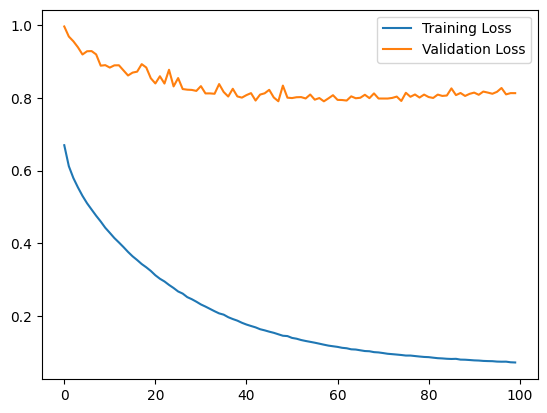

In [59]:
from matplotlib import pyplot

# Plot training and validation loss
pyplot.plot(history.history['loss'], label='Training Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.show()

### Saving the Model

In [60]:
# Serialize the model architecture to JSON
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
model.save_weights("NMT_model_weight.h5")

# Print a message to indicate successful model saving
print("Saved model to disk")

Saved model to disk


### Loading the Model

In [61]:
# Load the model architecture from a JSON file
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# Create a new model and load the architecture
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})

# Load the model weights from an HDF5 file into the new model
model_loaded.load_weights("NMT_model_weight.h5")

## Inference Model

In [62]:
latent_dim = 500

# Encoder Inference
encoder_inputs = model_loaded.input[0]
encoder_outputs, state_h, state_c = model_loaded.layers[6].output
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(9, latent_dim))
decoder_inputs = model_loaded.layers[3].output
dec_emb_layer = model_loaded.layers[5]
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# Dense softmax layer for generating probability distribution
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

## Predictions

In [63]:
def decode_sequence(input_seq):
    # Encode the input sequence to obtain the context vectors (e_out, e_h, e_c)
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Initialize the target sequence with the 'start' token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next token using the decoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Select the most likely token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # If 'end' is reached or maximum length is reached, stop
        if sampled_token_index == 0:
            break
        else:
            sampled_token = Mindex2word[sampled_token_index]
            if sampled_token != 'end':
                decoded_sentence += ' ' + sampled_token

        if sampled_token == 'end' or len(decoded_sentence.split()) >= (26 - 1):
            stop_condition = True

        # Update the target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

#### Creating Dictionaries

In [64]:
# Create dictionaries mapping token indices to words for English and Marathi
Eindex2word = englishTokenizer.index_word
Mindex2word = marathiTokenizer.index_word

### Converting a sequence to Human Readable Text

In [74]:
# Function to convert a sequence to a summary
# Add 'start' and 'end' tokens to the Mword2index dictionary
# Define your start and end tokens
start_token = 'start'
end_token = 'end'

# Add 'start' and 'end' tokens to the Mword2index dictionary
Mword2index[start_token] = len(Mword2index) + 1  # Assign a unique index
Mword2index[end_token] = len(Mword2index) + 1  # Assign another unique index

# Function to convert a sequence to a summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != Mword2index[start_token] and i != Mword2index[end_token]:
            newString += Mindex2word[i] + ' '
    return newString



# Function to convert a sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString += Eindex2word[i] + ' '
    return newString

### Checking our Model

In [77]:
import random

for i in range(50):
    # Choose a random index from the test data
    random_index = random.randint(0, len(X_test) - 1)
    
    # Print the review, original summary, and predicted summary for the randomly chosen index
    print("Review:", seq2text(X_test[random_index]))
    print("Original summary:", seq2summary(y_test[random_index]))
    print(X_test[random_index].shape)
    print("Predicted summary:", decode_sequence(X_test[random_index].reshape(1, 9)))
    print("\n")

Review: tom gave some milk to the cat 
Original summary: टॉमने मांजरीला जरासं दूध दिलं 
(9,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  मी एक आठवड्यापूर्वी काढला


Review: ill call them 
Original summary: मी त्यांना फोन करेन 
(9,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  त्यांना बोलव


Review: do you want to work with tom 
Original summary: तुला टॉमबरोबर काम करायचं आहे का 
(9,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  आमच्याबरोबर आहे का


Review: he continued reading the book 
Original summary: त्यांनी पुस्तक वाचणे चालू ठेवले 
(9,)
1/1 [==============================] - 0s 12ms/step
Predicted summary:  पुस्तक चालू राहिला


Review: look ahead 
Original summary: पुढे बघ 
(9,)
1/1 [==============================] - 0s 11ms/step
Predicted summary:  बघा


Review: whats your favorite sport 
Original summary: तुमचा आवडता खेळ कोणता आहे 
(9,)
1/1 [==============================] - 0s 12ms/step
Predicted s

Review: no one will tell you

Original summary: तुला कोणीही सांगणार नाही

Predicted summary: कोणीही तुला सांगणार नाही

## Custom Self-Attention Layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dot

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create learnable parameters (weights and bias) for attention
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='attention_weights')
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True,
                                 name='attention_bias')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Calculate query using learned weights and bias
        q = Dot(axes=(2, 2))([inputs, self.W])
        q += self.b
        q = tf.nn.tanh(q)
        scores = tf.nn.softmax(q, axis=-1)
        attention_output = Dot(axes=(2, 1))([scores, inputs])
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape

# Test the attention layer
# Assume input_shape = (batch_size, sequence_length, num_features)
input_shape = (None, 10, 64)  # Example input shape
inputs = tf.keras.Input(shape=input_shape)
attention_output = SelfAttention()(inputs)
model = tf.keras.Model(inputs=inputs, outputs=attention_output)
model.summary()